In [2]:
# imports
import os, random, torch, imageio, snnUtils
import pandas as pd, numpy as np, torch.nn as nn, gymnasium as gym, matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

In [ ]:
# "./Data/snnRL_256_128_64_32_1e-05_100_0.95_0.999_100_0.995_.pth"
# "Data\snnRL_256_128_64_32_1e-05_100_0.95_0.998_1000_0.995_TargetIsANN.pth"

In [25]:
# Network properties
fileName = "Data\snnRL_256_128_64_32_1e-05_100_0.95_0.998_1000_0.995_TargetIsANN.pth"
numLayers = 4
stateSize = [8]
nActions = 4
checkpointNumber = 0 # Enter 0 for latest saved state of neural network

# Set pytorch parameters: The device (CPU or GPU) and data types
__device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
__dtype = torch.float

# Network properties
lstDetails = os.path.basename(fileName).replace(".pth", "").split("_")
print(
    f"Project Name: {lstDetails[0]}\n",
    f"Network Layers: {lstDetails[1:numLayers+1]}\n",
    f"Learning Rate: {lstDetails[numLayers+1]}\n",
    f"Time steps: {lstDetails[numLayers+2]}\n",
    f"SNN Beta: {lstDetails[numLayers+3]}\n",
    f"Ebsilon decay rate: {lstDetails[numLayers+4]}\n",
    f"Minibatch Size: {lstDetails[numLayers+5]}\n",
    f"Gamma: {lstDetails[numLayers+6]}\n",
    f"Extra Info: {lstDetails[numLayers+7]}\n",
)

Project Name: snnRL
 Network Layers: ['256', '128', '64', '32']
 Learning Rate: 1e-05
 Time steps: 100
 SNN Beta: 0.95
 Ebsilon decay rate: 0.998
 Minibatch Size: 1000
 Gamma: 0.995
 Extra Info: TargetIsANN



In [14]:
class qNetwork_SNN(nn.Module):
    def __init__(self, inputSize, L1Size, L2Size, L3Size, L4Size, outputSize, **kwargs):
        super().__init__()

        # Model super parameters
        self.beta = kwargs["beta"]
        self.tSteps = kwargs["tSteps"]

        # Defining the layers
        self.layer1 = nn.Linear(inputSize, L1Size)
        self.L1LIF = snn.Leaky(beta = self.beta)
        self.layer2 = nn.Linear(L1Size, L2Size)
        self.L2LIF = snn.Leaky(beta = self.beta)
        self.layer3 = nn.Linear(L2Size, L3Size)
        self.L3LIF = snn.Leaky(beta = self.beta)
        self.layer4 = nn.Linear(L3Size, L4Size)
        self.L4LIF = snn.Leaky(beta = self.beta)
        self.output = nn.Linear(L4Size, outputSize)
        self.outputLIF = snn.Leaky(beta = self.beta)


    def forward(self, x):

        # Set initial potentials to be zero
        potential1 = self.L1LIF.reset_mem()
        potential2 = self.L2LIF.reset_mem()
        potential3 = self.L3LIF.reset_mem()
        potential4 = self.L4LIF.reset_mem()
        potential5 = self.outputLIF.reset_mem()

        # Save the state of the output layer
        L1_Spikes = []
        L1_Potentials = []
        L2_Spikes = []
        L2_Potentials = []
        L3_Spikes = []
        L3_Potentials = []
        L4_Spikes = []
        L4_Potentials = []
        outSpikes = []
        outPotentials = []

        # Save the state of the output layer
        outSpikes = []
        outPotentials = []

        # Iterate through time steps
        for t in range(self.tSteps):
            # First layer
            current1 = self.layer1(x)
            spk1, potential1 = self.L1LIF(current1, potential1)

            # Second layer
            current2 = self.layer2(spk1)
            spk2, potential2 = self.L2LIF(current2, potential2)

            # Third layer
            current3 = self.layer3(spk2)
            spk3, potential3 = self.L3LIF(current3, potential3)

            # Fourth layer
            current4 = self.layer4(spk3)
            spk4, potential4 = self.L4LIF(current4, potential4)

            #Output
            current5 = self.output(spk4)
            spk5, potential5 = self.outputLIF(current5, potential5)
            
            # Save output
            L1_Spikes.append(spk1)
            L1_Potentials.append(potential1)
            L2_Spikes.append(spk2)
            L2_Potentials.append(potential2)
            L3_Spikes.append(spk3)
            L3_Potentials.append(potential3)
            L4_Spikes.append(spk4)
            L4_Potentials.append(potential4)
            outSpikes.append(spk5)
            outPotentials.append(potential5)

        returnDict = {
            "spikes": {
                "L1": torch.stack(L1_Spikes, dim = 0),
                "L2": torch.stack(L2_Spikes, dim = 0),
                "L3": torch.stack(L3_Spikes, dim = 0),
                "L4": torch.stack(L4_Spikes, dim = 0),
                "out": torch.stack(outSpikes, dim = 0),
            },
            "potentials": {
                "L1": torch.stack(L1_Potentials, dim = 0),
                "L2": torch.stack(L2_Potentials, dim = 0),
                "L3": torch.stack(L3_Potentials, dim = 0),
                "L4": torch.stack(L4_Potentials, dim = 0),
                "out": torch.stack(outPotentials, dim = 0),
            },
        }

        return torch.stack(outSpikes, dim = 0).sum(dim = 0), returnDict
    
qNetwork_model = qNetwork_SNN(
    stateSize[0], 
    int(lstDetails[1:numLayers+1][0]), 
    int(lstDetails[1:numLayers+1][1]),
    int(lstDetails[1:numLayers+1][2]), 
    int(lstDetails[1:numLayers+1][3]), 
    nActions, 
    beta = float(lstDetails[numLayers+3]), 
    tSteps = int(lstDetails[numLayers+2])).to(__device, dtype = __dtype)

# Load the network
checkpoints = torch.load(fileName, map_location = __device)
checkpoints =  checkpoints if isinstance(checkpoints, list) else [checkpoints]
qNetwork_model.load_state_dict(checkpoints[checkpointNumber]["qNetwork_state_dict"])

C:\Users\Spino.shop\AppData\Local\Temp\ipykernel_4360\308945121.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(fileName, map_location = __dev

<All keys matched successfully>

C:\Users\Spino.shop\AppData\Local\Temp\ipykernel_4360\28025439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load(fileName, map_location = __device

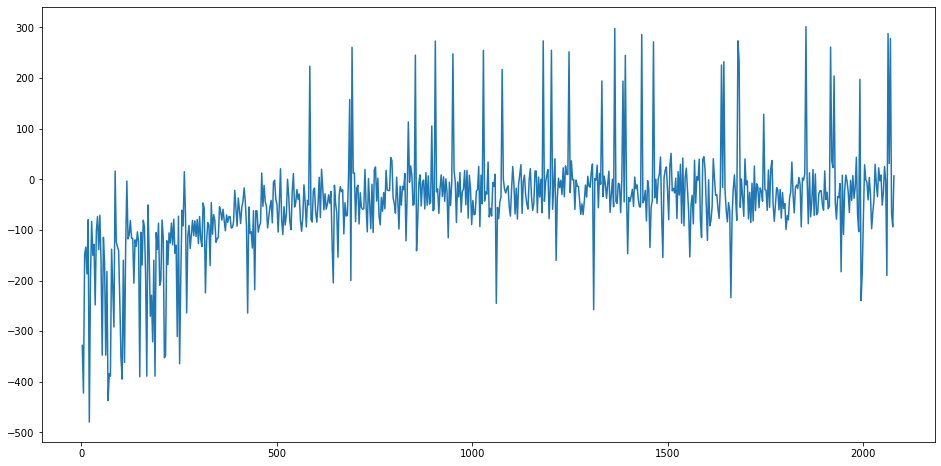

In [26]:
# Plot the training average points
checkpoints = torch.load(fileName, map_location = __device)
checkpoints =  checkpoints if isinstance(checkpoints, list) else [checkpoints]
dfHist = pd.DataFrame(checkpoints[checkpointNumber]["train_history"])

fig = plt.figure(figsize=(16,8))
plt.plot(dfHist["episode"], dfHist["points"])

In [37]:
# Test a simulation
seed = random.randint(0, 1_000_000_000)
environment = gym.make("LunarLander-v3", render_mode = "rgb_array")

lstActions = []
lstStates = []
lstNetworkDetails = []
state, _ = environment.reset(seed = seed)
points = 0

maxStepN = 1000
qNetwork_model.eval()

videoWriter = imageio.get_writer("./Data/runVideo.gif")

for t in range(maxStepN):
    print('Step', t, "| Point", f"{points:.2f}",  end='\r')
    
    # Take greedy steps
    optimalAction, details = qNetwork_model(torch.tensor(state, device = __device, dtype = __dtype))
    lstNetworkDetails.append(details)
    action = torch.argmax(optimalAction)

    state, reward, terminated, truncated, _ = environment.step(action.item())
    videoWriter.append_data(environment.render())
    
    lstActions.append(action)
    lstStates.append(state)
    
    points += reward
    if terminated or truncated:
        videoWriter.close()
        break


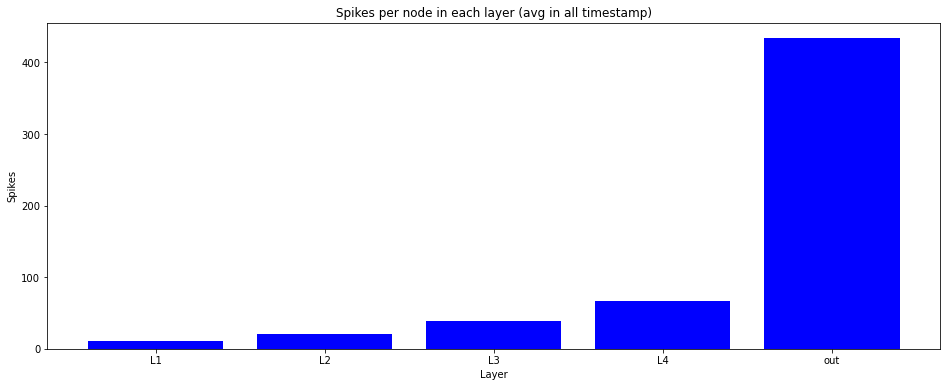

In [38]:
spikeCount = dict()
_temp = np.array([])

for layer in lstNetworkDetails[0]["spikes"].keys():
    for i in range(len(lstNetworkDetails)):
        _temp = np.append(_temp, lstNetworkDetails[i]["spikes"][layer].sum(dim = 0).sum(dim = 0).cpu().detach().numpy())
    spikeCount.update({layer: np.average(_temp)/lstNetworkDetails[0]["spikes"][layer].shape[1]})


# Data for the bar chart
items = list(spikeCount.keys())
quantities = list(spikeCount.values())

# Create the bar chart
fig = plt.figure(figsize=(16, 6))
plt.bar(items, quantities, color=['blue', 'blue', 'blue', 'blue', 'blue'])

# Add title and labels
plt.title('Spikes per node in each layer (avg in all timestamp)')
plt.xlabel('Layer')
plt.ylabel('Spikes')

# Display the chart
plt.show()

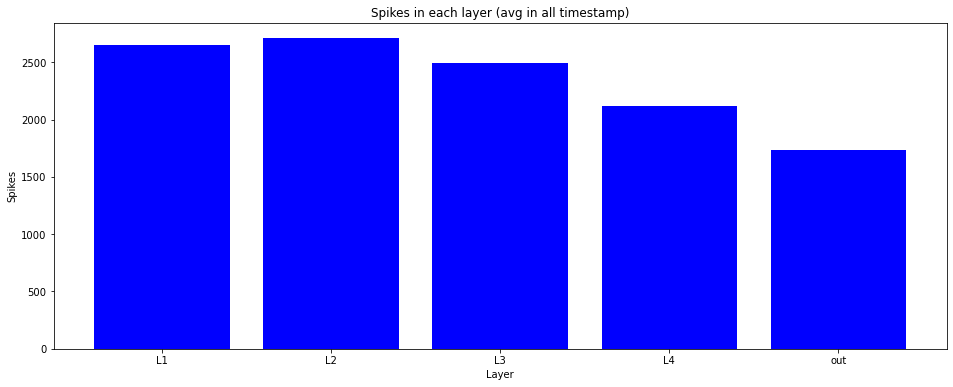

In [39]:
spikeCount = dict()
_temp = np.array([])

for layer in lstNetworkDetails[0]["spikes"].keys():
    for i in range(len(lstNetworkDetails)):
        _temp = np.append(_temp, lstNetworkDetails[i]["spikes"][layer].sum(dim = 0).sum(dim = 0).cpu().detach().numpy())
    spikeCount.update({layer: np.average(_temp)})


# Data for the bar chart
items = list(spikeCount.keys())
quantities = list(spikeCount.values())

# Create the bar chart
fig = plt.figure(figsize=(16, 6))
plt.bar(items, quantities, color=['blue', 'blue', 'blue', 'blue', 'blue'])

# Add title and labels
plt.title('Spikes in each layer (avg in all timestamp)')
plt.xlabel('Layer')
plt.ylabel('Spikes')

# Display the chart
plt.show()